In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates

# --- 1. Data Loading & Prep ---
# Load the results (Assuming files are in the working directory)
df_unmarked = pd.read_csv('../data/all_day_results.csv')
df_marked = pd.read_csv('../data/all_day_marked_results.csv')


In [3]:
df_unmarked.head()

,Unnamed: 0,mu_buy,mu_sell,alpha_bb,alpha_bs,alpha_sb,alpha_ss,beta,br_bb,br_bs,br_sb,br_ss,spectral_radius,total_branching,log_likelihood,is_stationary
0,2019-08-13,1.000000e-10,1.592256e-05,11110.233936,4328.096229,3885.044399,9725.681382,24563.963993,0.452298,0.176197,0.158160,0.395933,0.593413,1.182588,1.470278e+06,True
1,2019-08-14,1.122070e-05,1.000000e-10,48099.381852,31626.902075,33895.498939,45455.451690,99999.813684,0.480995,0.316270,0.338956,0.454555,0.795458,1.590775,1.550959e+06,True
2,2019-08-16,6.763133e-05,1.000000e-10,4372.033916,356.632035,142.494795,2008.722547,6856.359803,0.637661,0.052015,0.020783,0.292972,0.640769,1.003431,9.946942e+05,True
3,2019-08-19,1.000000e-10,7.772353e-05,28664.668389,23017.421771,33093.052836,23789.058743,88075.556987,0.325455,0.261337,0.375735,0.270098,0.612355,1.232626,1.042638e+06,True
4,2019-08-20,1.000000e-10,1.000000e-10,25399.988192,25188.971964,369.792795,25445.020270,51008.804132,0.497953,0.493816,0.007250,0.498836,0.558229,1.497855,1.287517e+06,True


In [4]:
df_unmarked['Unnamed: 0']

0    2019-08-13
1    2019-08-14
2    2019-08-16
3    2019-08-19
4    2019-08-20
5    2019-08-21
6    2019-08-22
7    2019-08-23
8    2019-08-26
9    2019-08-27
Name: Unnamed: 0, dtype: object

In [5]:
df_unmarked.rename(columns={"Unnamed: 0": "date"}, inplace=True)
df_marked.rename(columns={"Unnamed: 0": "date"}, inplace=True)

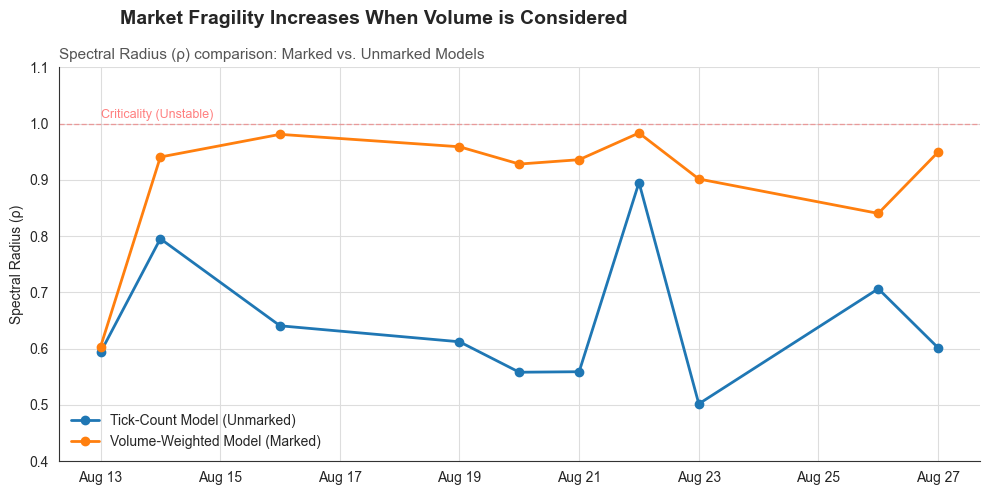

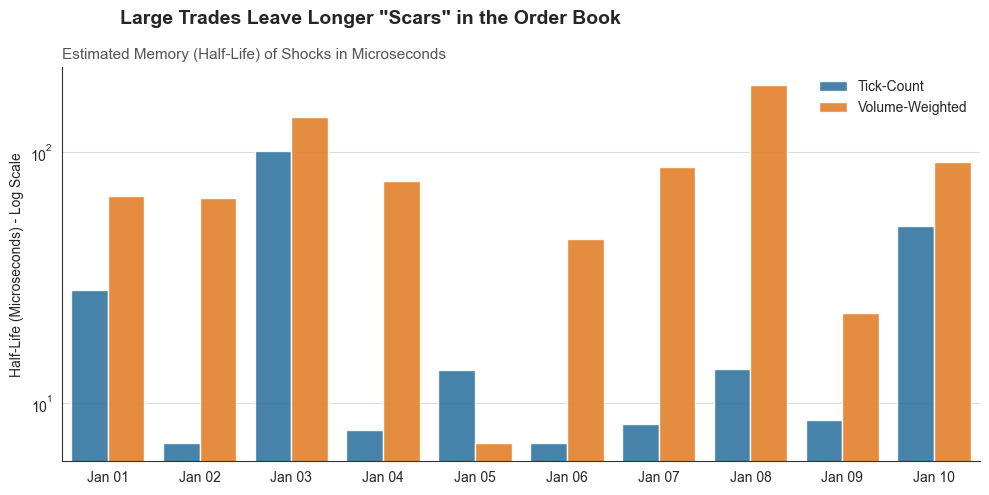

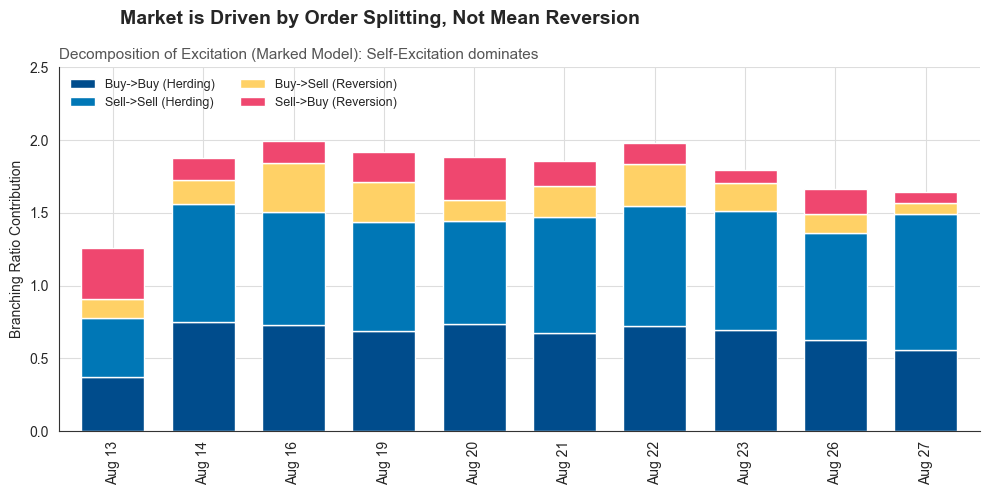

In [6]:
# Convert date to datetime objects for better plotting
df_unmarked['date'] = pd.to_datetime(df_unmarked['date'])
df_marked['date'] = pd.to_datetime(df_marked['date'])

# Calculate Half-Life in Microseconds (ln(2) / beta * 1,000,000)
# Note: Data is in seconds, so we multiply by 1e6 to get microseconds
df_unmarked['half_life_us'] = (np.log(2) / df_unmarked['beta']) * 1e6
df_marked['half_life_us'] = (np.log(2) / df_marked['beta']) * 1e6

# Merge for comparison plots
df_compare = pd.merge(
    df_unmarked[['date', 'spectral_radius', 'half_life_us']], 
    df_marked[['date', 'spectral_radius', 'half_life_us']], 
    on='date', 
    suffixes=('_tick', '_vol')
)

# --- 2. Style Setup (User Constraints) ---
# Tableau-style Blue (Tick) and Orange (Volume)
# Light background, high data-ink ratio
colors = {'Tick': '#1F77B4', 'Volume': '#FF7F0E'} # Tableau Blue/Orange
sns.set_style("whitegrid")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['grid.color'] = '#dddddd'

# --- Plot 1: The Fragility Gap (Spectral Radius) ---
fig, ax = plt.subplots(figsize=(10, 5))

# Plot Lines
ax.plot(df_compare['date'], df_compare['spectral_radius_tick'], 
        marker='o', color=colors['Tick'], label='Tick-Count Model (Unmarked)', linewidth=2)
ax.plot(df_compare['date'], df_compare['spectral_radius_vol'], 
        marker='o', color=colors['Volume'], label='Volume-Weighted Model (Marked)', linewidth=2)

# Criticality Line
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.text(df_compare['date'].iloc[0], 1.01, 'Criticality (Unstable)', color='red', fontsize=9, alpha=0.5)

# Formatting
ax.set_ylim(0.4, 1.1)
ax.set_ylabel('Spectral Radius (ρ)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.legend(frameon=False, loc='lower left')

# Actionable Titles
plt.suptitle('Market Fragility Increases When Volume is Considered', 
             fontsize=14, fontweight='bold', x=0.125, ha='left')
ax.set_title('Spectral Radius (ρ) comparison: Marked vs. Unmarked Models', 
             fontsize=11, color='#555555', loc='left')

plt.tight_layout()
plt.show()

# --- Plot 2: The Memory of Liquidity (Half-Life) ---
fig, ax = plt.subplots(figsize=(10, 5))

# Prepare Data for Bar Plot
df_melt = df_compare.melt(id_vars='date', 
                          value_vars=['half_life_us_tick', 'half_life_us_vol'],
                          var_name='Model', value_name='half_life')
df_melt['Model'] = df_melt['Model'].map({'half_life_us_tick': 'Tick-Count', 'half_life_us_vol': 'Volume-Weighted'})

# Plot
sns.barplot(data=df_melt, x='date', y='half_life', hue='Model', 
            palette=[colors['Tick'], colors['Volume']], ax=ax, alpha=0.9)

# Formatting
ax.set_yscale("log") # Log scale because volume memory is order of magnitude larger
ax.set_ylabel('Half-Life (Microseconds) - Log Scale')
ax.set_xlabel('')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.legend(frameon=False, title=None)

# Actionable Titles
plt.suptitle('Large Trades Leave Longer "Scars" in the Order Book', 
             fontsize=14, fontweight='bold', x=0.125, ha='left')
ax.set_title('Estimated Memory (Half-Life) of Shocks in Microseconds', 
             fontsize=11, color='#555555', loc='left')

plt.tight_layout()
plt.show()

# --- Plot 3: Anatomy of Herding (Branching Ratios - Marked Only) ---
# We focus on the Marked model to show the "Diagonal Dominance"
fig, ax = plt.subplots(figsize=(10, 5))

# Prepare Data
df_ratios = df_marked[['date', 'br_bb', 'br_bs', 'br_sb', 'br_ss']].copy()
df_ratios['date'] = df_ratios['date'].dt.strftime('%b %d')
df_ratios = df_ratios.set_index('date')

# Stacked Bar Plot
# Blue shades for Self-Excitation (BB, SS), Grey/Orange for Cross (BS, SB)
colors_stack = ['#1F77B4', '#AEC7E8', '#FFBB78', '#FF7F0E'] # Tableau variants
# Reorder columns for logical stacking: Self-Buy, Self-Sell (Base), then Cross
df_plot = df_ratios[['br_bb', 'br_ss', 'br_sb', 'br_bs']]
# Rename for legend clarity
df_plot.columns = ['Buy->Buy (Herding)', 'Sell->Sell (Herding)', 'Buy->Sell (Reversion)', 'Sell->Buy (Reversion)']

df_plot.plot(kind='bar', stacked=True, ax=ax, color=['#004c8c', '#0077b6', '#ffd166', '#ef476f'], width=0.7)

# Formatting
ax.set_ylabel('Branching Ratio Contribution')
ax.set_xlabel('')
ax.legend(frameon=False, loc='upper left', ncol=2, fontsize=9)
ax.set_ylim(0, 2.5) # Based on your data total_branching ~ 1.5-2.0

# Actionable Titles
plt.suptitle('Market is Driven by Order Splitting, Not Mean Reversion', 
             fontsize=14, fontweight='bold', x=0.125, ha='left')
ax.set_title('Decomposition of Excitation (Marked Model): Self-Excitation dominates', 
             fontsize=11, color='#555555', loc='left')

plt.tight_layout()
plt.show()